In [101]:
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

from typing import List, Dict
from gretel_client import configure_session

In [102]:
# Specify your Gretel API key

pd.set_option("max_colwidth", None)

configure_session(api_key='grtu9cd34f3901cfac9e13f08002d42705fcbb214dca7a7731179c6a318cb2af2e0a', cache="yes", validate=True)


Using endpoint https://api.gretel.cloud
Logged in as hoang.nd@orai.io ✅


In [103]:
# Load timeseries example to a dataframe

data_source = "./AAPL Historical Data.csv"
original_df = pd.read_csv(data_source)
original_df.to_csv("original.csv", index=False)
original_df


,01/01/2017,908.8
0,01/08/2017,815.3
1,01/15/2017,924.0
2,01/22/2017,919.4
3,01/29/2017,1031.1
4,02/05/2017,1000.3
...,...,...
255,11/28/2021,49272.0
256,12/05/2021,49363.1
257,12/12/2021,46879.0
258,12/19/2021,50437.0


In [104]:
# Gretel Transforms Configuration
config = """
schema_version: "1.0"
models:
    - transforms:
        data_source: "__tmp__"
        policies:
            - name: shiftnumbers
              rules:
                - name: shiftnumbers
                  conditions:
                    field_name:
                        - Price
                  transforms:
                    - type: numbershift
                      attrs:
                        min: 1
                        max: 100
                        field_name:
                            - Date
              
"""


In [105]:
# De-identify the original dataset using the policy above
import yaml

from gretel_client.projects import create_or_get_unique_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_or_get_unique_project(name="numbershift-transform")

model = project.create_model_obj(
    model_config=yaml.safe_load(config), data_source=data_source
)

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

record_handler = model.create_record_handler_obj(data_source=data_source)
record_handler.submit_cloud()
poll(record_handler)

deid_df = pd.read_csv(record_handler.get_artifact_link("data"), compression="gzip")


INFO: Starting poller


{
    "uid": "6343a2b65a40d35d0009fdba",
    "guid": "model_2FveOAaMSKaAzFIGRKfPsEhw7GI",
    "model_name": "puzzled-hulking-lizard",
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633ffe8e44a4f15b630a3527",
    "project_guid": "proj_2FnqhzkG3XtUbB0nSxJQHK6Y0fU",
    "status_history": {
        "created": "2022-10-10T04:42:30.694589Z"
    },
    "last_modified": "2022-10-10T04:42:30.804604Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/transforms@sha256:c9b59a72bc0f0d73111d7bc7e52a9c5b8cb6eb44734caa23dc02b1672fa7fc51",
    "container_image_version": "2.10.0",
    "model_type": "transform",
    "config": {
        "schema_vers

INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!


In [ ]:
# Here we sort and remove "net_amt" as it's a derived column,
# We will add back in after the data is synthesized
train_df = deid_df.copy()

train_df.sort_values("Date", inplace=True)
train_cols = list(train_df.columns)
train_df = train_df.filter(train_cols)

# Here we noticed that some number have extremely long precision,
# so we round the data
train_df = train_df.round(1)
train_df.to_csv("train.csv", index=False)
train_df


,Date,Price
2,01/01/2014,110.9
14,01/01/2015,51.3
26,01/01/2016,110.3
38,01/01/2017,93.3
3,02/01/2014,22.8
15,02/01/2015,33.1
27,02/01/2016,38.2
39,02/01/2017,94.2
4,03/01/2014,107.2
16,03/01/2015,36.1


In [ ]:
from gretel_client.projects.models import read_model_config

# Create a project and model configuration.
project = create_or_get_unique_project(name="ts-5544-regular-seed")

# Pull down the default synthetic config.  We will modify it slightly.
config = read_model_config("synthetics/default")

# Set up the seed fields
seed_fields = ["Date"]

task = {
    "type": "seed",
    "attrs": {
        "fields": seed_fields,
    },
}

# Fine tune model parameters. These are the parameters we found to work best.  This is "Run 20" in the document
config['models'][0]['synthetics']['task'] = task
 
config["models"][0]["synthetics"]["params"]["vocab_size"] = 20
config["models"][0]["synthetics"]["params"]["learning_rate"] = 0.005
config["models"][0]["synthetics"]["params"]["epochs"] = 100
config["models"][0]["synthetics"]["params"]["gen_temp"] = 0.8
config["models"][0]["synthetics"]["params"]["reset_states"] = True
config["models"][0]["synthetics"]["params"]["dropout_rate"] = 0.5
config["models"][0]["synthetics"]["params"]["gen_temp"] = 0.8
config["models"][0]["synthetics"]["params"]["early_stopping"] = True
config["models"][0]["synthetics"]["privacy_filters"]["similarity"] = None
config["models"][0]["synthetics"]["privacy_filters"]["outliers"] = None
config["models"][0]["synthetics"]["generate"]["num_records"] = train_df.shape[0]

# Get a csv to work with, just dump out the train_df.
deid_df.to_csv("train.csv", index=False)

# Initiate a new model with the chosen config
model = project.create_model_obj(model_config=config, data_source="train.csv")

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

synthetic = pd.read_csv(model.get_artifact_link("data_preview"), compression="gzip")
synthetic


INFO: Starting poller


{
    "uid": "6343a2245a40d35d0009fdb9",
    "guid": "model_2Fve5q3XqykdV7txdjGnOnOCP2I",
    "model_name": "default-config",
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633fff1f44a4f15b630a3529",
    "project_guid": "proj_2Fnr0BIix7lRhD3Z2BF0BFNT0b7",
    "status_history": {
        "created": "2022-10-10T04:40:04.269690Z"
    },
    "last_modified": "2022-10-10T04:40:04.363369Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:3339cda15d1ac57a84a12275267fe2f59cf27b43e00b916e8f4f154b5e8398a1",
    "container_image_version": "2.10.0",
    "model_type": "synthetics",
    "config": {
        "schema_version": "

INFO: Status is created. Model creation has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2022-10-10T04:40:25.517029Z  Starting synthetic model training
2022-10-10T04:40:25.519919Z  Loading training data
2022-10-10T04:40:25.691737Z  Running pre-flight data checks on input data
2022-10-10T04:40:25.721655Z  We found 1 warning. If your model fails, try modifying the fields or adjusting your configuration settings.

	1 field with high floating point precision: 'Price' has floats with precision greater than 6 digits. Try reducing precision to 4 digits.
2022-10-10T04:40:25.739164Z  Training data loaded
{
    "record_count": 49,
    "field_count": 2,
    "upsample_count": 9951
}
2022-10-10T04:40:28.415308Z  Creating semantic validators and preparing training data
2022-10-10T04:40:29.351907Z  Beginning ML model training
2022-10-10T04:40:29.352353Z  Running training on 1 b

,Date,Price
0,11/01/2013,84.86
1,12/01/2013,106.04
2,01/01/2014,110.88
3,02/01/2014,22.79
4,03/01/2014,107.17
5,04/01/2014,53.07
6,05/01/2014,53.61
7,06/01/2014,71.23
8,07/01/2014,73.90
9,08/01/2014,62.62


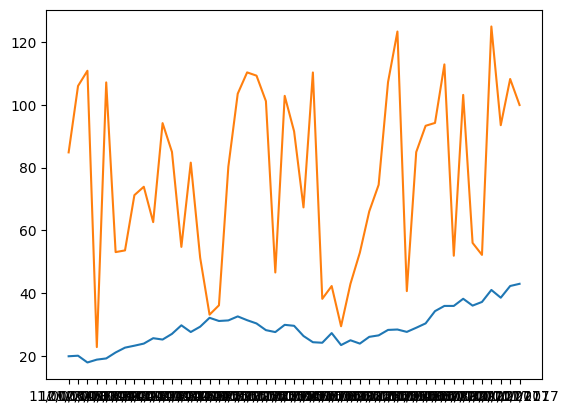

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


data = pd.read_csv('./original.csv')
data_new = pd.read_csv('./train.csv')
plt.plot(data['Date'],data['Price'],data_new['Date'],data_new['Price'])

